![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
print(tweets)

                   airline_sentiment  airline_sentiment_confidence  \
tweet_id                                                             
570306133677760513           neutral                        1.0000   
570301130888122368          positive                        0.3486   
570301083672813571           neutral                        0.6837   
570301031407624196          negative                        1.0000   
570300817074462722          negative                        1.0000   
...                              ...                           ...   
569587686496825344          positive                        0.3487   
569587371693355008          negative                        1.0000   
569587242672398336           neutral                        1.0000   
569587188687634433          negative                        1.0000   
569587140490866689           neutral                        0.6771   

                            negativereason  negativereason_confidence  \
tweet_id        

In [6]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [7]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [8]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

In [9]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

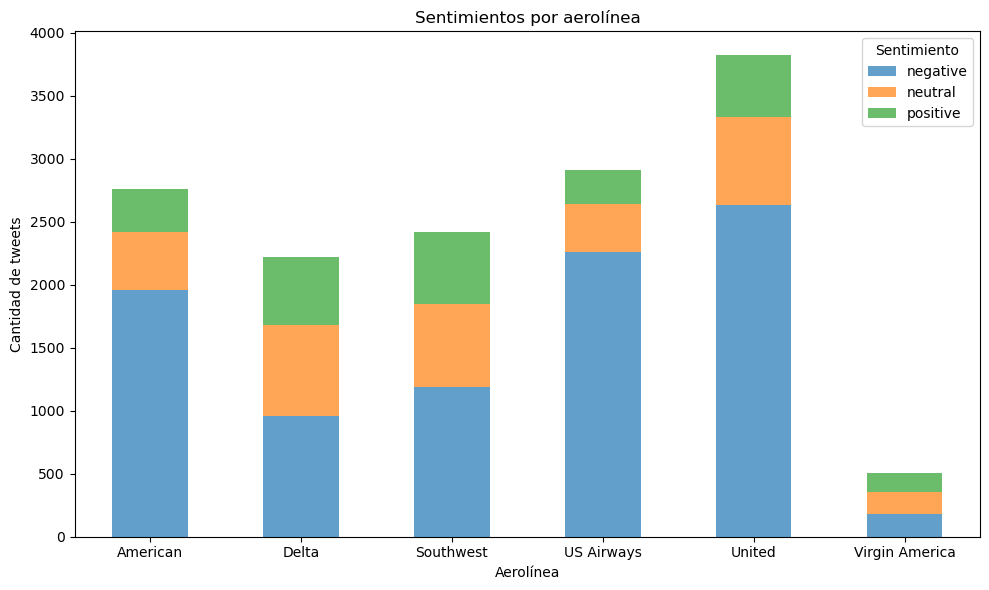

In [22]:
# Gráfico de barras apiladas de sentimientos por aerolínea
pd.crosstab(index=tweets["airline"],
            columns=tweets["airline_sentiment"])\
  .plot(kind='bar',
        figsize=(10, 6),
        alpha=0.7,
        rot=0,
        stacked=True)

plt.title("Sentimientos por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Cantidad de tweets")
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()

### Liberias y Variables de interés y predicción

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import accuracy_score

In [12]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [13]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [15]:
# Celda 1

# 1. Vectorización del texto
vectorizer = CountVectorizer(lowercase=True)

# Ajustar solo con el set de entrenamiento
X_train_vec = vectorizer.fit_transform(X_train)

# Transformar el set de test
X_test_vec = vectorizer.transform(X_test)

# 2. Entrenamiento del modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_vec, y_train)

# 3. Predicción sobre el set de test
y_pred = rf_model.predict(X_test_vec)

# 4. Evaluación del modelo
accuracyCV = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo: {accuracyCV:.4f}')

Accuracy del modelo: 0.7711


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [16]:
# Celda 2

# 1. Vectorización del texto con eliminación de stopwords
vect_no_stopw = CountVectorizer(stop_words='english', lowercase=True)

# Ajustar solo con los datos de entrenamiento
X_train_vec = vect_no_stopw.fit_transform(X_train)

# Transformar los datos de test
X_test_vec = vect_no_stopw.transform(X_test)

# 2. Entrenamiento del modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_vec, y_train)

# 3. Predicciones sobre el set de test
y_pred = rf_model.predict(X_test_vec)

# 4. Evaluación del modelo con accuracy
accuracySW = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo (sin stopwords): {accuracySW:.4f}')

Accuracy del modelo (sin stopwords): 0.7618


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [17]:
# Celda 3

# Descargar 'wordnet' de nltk si no está instalado
nltk.download('wordnet')

# Lematizador de WordNet
wordnet_lemmatizer = WordNetLemmatizer()

# Definir función para lematizar como verbos
def split_into_lemmas(text):
    text = text.lower()  # Convertir a minúsculas
    words = text.split()  # Separar el texto en palabras
    return [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]  # Lematizar las palabras como verbos

# 1. Vectorización del texto con lematización de verbos
vect_lemas = CountVectorizer(analyzer=split_into_lemmas)

# Ajustar solo con el set de entrenamiento
X_train_vec = vect_lemas.fit_transform(X_train)

# Transformar el set de test
X_test_vec = vect_lemas.transform(X_test)

# 2. Entrenamiento del modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_vec, y_train)

# 3. Predicción sobre el set de test
y_pred = rf_model.predict(X_test_vec)

# 4. Evaluación del modelo con accuracy
accuracyLM = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo con lematización de verbos: {accuracyLM:.4f}')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy del modelo con lematización de verbos: 0.7612


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [19]:
# Lematizador como verbo
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_as_verbs(text):
    words = str(text).lower().split()
    return [lemmatizer.lemmatize(word, pos='v') for word in words]

# Vectorización con CountVectorizer + stopwords + lematización como verbos
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', analyzer=lemmatize_as_verbs)

X_train_vectf = vectorizer.fit_transform(X_train)
X_test_vectf = vectorizer.transform(X_test)

# Optimización con GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train_vectf, y_train)

# Evaluación
print("Mejores hiperparámetros:", grid.best_params_)
print("Accuracy (CV):", grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test_vectf)
print("Accuracy (test):", accuracy_score(y_test, y_pred))

accuracyRFALL=accuracy_score(y_test, y_pred)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}
Accuracy (CV): 0.7585635174775304
Accuracy (test): 0.7847682119205298


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

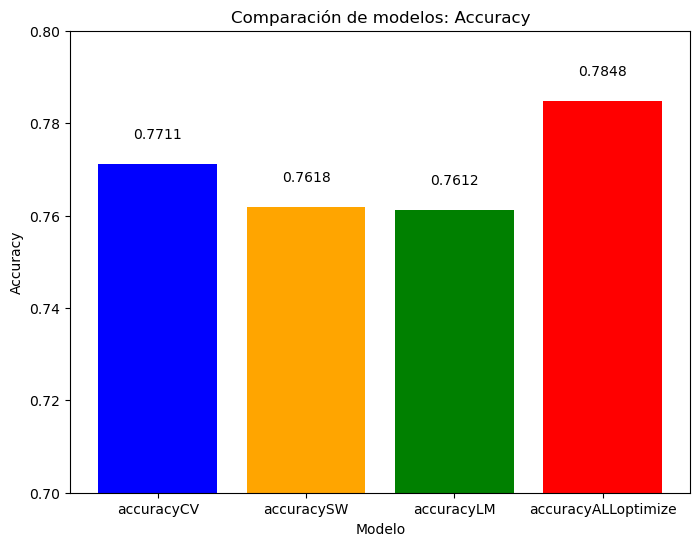

In [23]:
# Celda 5

# Definimos las métricas
accuracies = {
    'accuracyCV': accuracyCV,  # Accuracy con stopwords eliminados
    'accuracySW': accuracySW,  # Accuracy sin stopwords
    'accuracyLM': accuracyLM,  # Accuracy con lematización
    'accuracyALLoptimize':accuracyRFALL # Acuracy con CountVectorizer, eliminen stopwords, lematizen el texto con verbos y modelo de random forest
}


# Crear gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green', 'red','yellow'])

# Añadir etiquetas sobre las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom')

plt.title('Comparación de modelos: Accuracy')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)  # Limitar el rango de y para ver mejor la comparación
plt.show()

En la comparación de modelos se evaluaron distintas combinaciones de técnicas de procesamiento de texto aplicadas a un clasificador Random Forest, de acuerdo a lo solicitado en los enunciados. El modelo base con CountVectorizer logró un desempeño aceptable (accuracy de 77.11%), mientras que la variacion de modelo con eliminación de stopwords redujo ligeramente la precisión (76.18%), posiblemente porque ciertos stopwords permiten para determinar de forma más precisa el sentimiento (hipótesis). La lematización por sí sola tampoco mejoró el rendimiento, obteniendo un accuracy similar (76.12%), lo que sugiere que reducir las palabras a su forma verbal sin otros ajustes no es suficiente para mejorar la capacidad predictiva del modelo.

El mejor desempeño fue alcanzado por el modelo que combinó CountVectorizer, eliminación de stopwords, lematización como verbos y una optimización de hiperparámetros con GridSearchCV, logrando un accuracy de 78.48%. La mejora se debe a que permite que el modelo obtenga representaciones del texto más limpias y modifique los parámetros del modelo a fin de adaptarse mejor a los datos. Una de las ventajas es la robustez general y el incremento del rendimiento en terminos d e accuracy, aunque su desventaja es el aumento del tiempo computacional, puesto que tardó en términos de tiempo de ejecución más de tres veces más que los otros modelos. En conclusión, la combinación de técnicas de pre-procesamiento lingüístico junto con el ajuste del modelo permitirá mejorar significativamente el rendimiento en tareas de análisis de sentimientos, al menos para este problema y con estos datasets; es importante resaltar que la optimización d eaprametros fue fundamental en la mejora del accuracy. 